In [1]:
#packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.utils import resample
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [2]:
#dataset import
#test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("validation.csv")

#Apply CTR estimation to create linear bidding strategy, proportional to pCTR

#bid = base_bid * pCTR /avgCTR
#base_bid - the big price for the avg CTR cases


Apply CTR estimation to create a linear bidding strategy. The bid value is linearly proportional to the pCTR
(predicted CTR). The formula can be generally written as
bid = base bid×pCT R/avgCTR, 
where the tuning parameter
base bid is the bid price for the average CTR cases. Optimise the base bid and the CTR estimation and evaluate the
performance of your model using the metrics as defined in
Section 3.3. Discuss and compare your results.

mCPC - the max cost per click

Linear-form bidding of pCTR (Lin) - Parametic as it considers the bugit limit when the parameters are tuned.
Also needs to evaluate the CTR for each impression

CTR - click through rate - # of clicks over winning impressions

In [3]:
# check the action win rate for impressions
win_rate = round(len(train_data.loc[train_data['bidprice'] > train_data['payprice']])*100/len(train_data), 2)
print(str(win_rate) + "% impression win rate")

99.89% impression win rate


In [4]:
#limit dataset to include data where bids result in an impression

train_data = train_data.loc[train_data['bidprice'] > train_data['payprice']]
train_data['adexchange'] = train_data['adexchange'].fillna(0)
train_data.head(3)

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,...,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,...,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,...,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"


In [7]:
print("click mean ::::: %.3f" % train_data['click'].mean())

print(" ")

print("Number of clicks vs non-clicks :::")
print(train_data['click'].value_counts())

print(" ")

print("Ratio of all data that resulted in their a click or didn't result in a click :::")
print(train_data['click'].value_counts()/len(train_data))

click mean ::::: 0.001
 
Number of clicks vs non-clicks :::
0    2426443
1       1785
Name: click, dtype: int64
 
Ratio of all data that resulted in their a click or didn't result in a click :::
0    0.999265
1    0.000735
Name: click, dtype: float64


In [8]:
'''Because there is such a huge disparity between non-clicks vs clicks, we'll perform a:
Negative downsampling (imbalanced): different samples sizes are used in this procedure. 
In all these samples all the observations from the minority class are kept and 
we take different number of observations from the majority class by performing sampling without replacement.
'''
# Separate majority and minority classes
train_data_majority = train_data[train_data.click==0]
train_data_minority = train_data[train_data.click==1]
 
# Downsample majority class
df_majority_downsampled = resample(train_data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1785,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
train_data = pd.concat([df_majority_downsampled, train_data_minority])
 
# Display new class counts
train_data.click.value_counts()

1    1785
0    1785
Name: click, dtype: int64

277


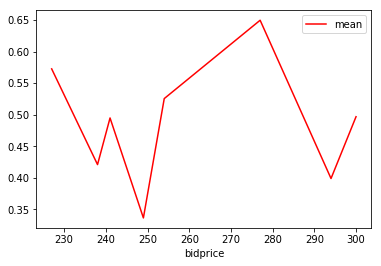

,mean
bidprice,
277,0.649510
227,0.572559
254,0.525510
300,0.496806
241,0.494845
238,0.421053
294,0.399015
249,0.336634


In [45]:
#Data Exploration

# Determine average click through rate based on useragent
useragent_mean = train_data.groupby('useragent')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
#useragent_mean

# Determine average click through rate based on advertiser
advertiser_mean = train_data.groupby('advertiser')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
#advertiser_mean

# Determine average click through rate based on pricing of the slot
slotprice_mean = train_data.groupby('slotprice')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
#slotprice_mean

# Determine average click through rate based on pricing bidding
bidprice_mean = train_data.groupby('bidprice')['click'].agg(['mean']).sort_values(['mean'],ascending=False)


fig, ax = plt.subplots()
average_bids = train_data.groupby('bidprice')['click'].agg(['mean'])
print(train_data.groupby('bidprice')['click'].agg(['mean']).sort_values(['mean'],ascending=False).index[0])
train_data.groupby('bidprice')['click'].agg(['mean']).plot(ax=ax, c='red', label='unclicked')
plt.show()

bidprice_mean

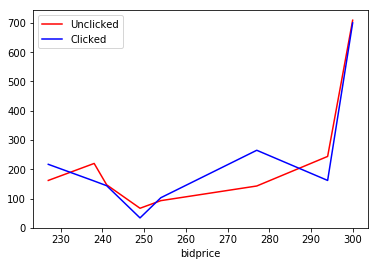

0.5

In [49]:
unclick_ad = train_data.loc[train_data['click'] ==0]
clicked_ad = train_data.loc[train_data['click'] ==1]

fig, ax = plt.subplots()
unclick_ad.groupby('bidprice')['click'].agg(['count']).plot(ax=ax, c='red', label='unclicked')
clicked_ad.groupby('bidprice')['click'].agg(['count']).plot(ax=ax, c='blue', label='clicked')

L = plt.legend()
L.get_texts()[0].set_text('Unclicked')
L.get_texts()[1].set_text('Clicked')

plt.show()

In [46]:
'''create a dataframe from this df that includes all the features we want to test
commented out id and key columns '''

model_df = train_data[
['click',
 'weekday',
 'hour',
 #'bidid',
 #'userid',
 'useragent',
 #'IP',
 'region',
 'city',
 'adexchange',
 #'domain',
 #'url',
 #'urlid',
 #'slotid',
 'slotwidth',
 'slotheight',
 'slotvisibility',
 'slotformat',
 'slotprice',
 #'creative',
 'bidprice',
 'payprice',
 'keypage',
 'advertiser',
 #'usertag'
]]

model_df = pd.get_dummies(model_df, columns=['useragent','slotvisibility', 'slotformat', 'keypage'], 
               prefix=['useragent','slotvisibility', 'slotformat', 'keypage'])

model_df.head()

,click,weekday,hour,region,city,adexchange,slotwidth,slotheight,slotprice,bidprice,...,keypage_a5d0bde104fea52ea466c77b37948424,keypage_a8f8eeaae5c1e2e9924328e78d9925a5,keypage_aa4976c67db0f076c563a29f6697928b,keypage_b2e35064f3549d447edbbdfb1f707c8c,keypage_bebefa5efe83beee17a3d245e7c5085b,keypage_c8758e8658b05bc3a88af7b37bdf0575,keypage_d29e59bf0f7f8243858b8183f14d4412,keypage_d41d8cd98f00b204e9800998ecf8427e,keypage_d4fc4aa65f6670f7fea6862f27084fbc,keypage_f4a09c06b67d0fcce088ee6e86ca052a
2185427,0,4,16,27,34,0.0,320,50,5,277,...,0,0,0,0,0,0,0,0,0,0
946685,0,6,19,3,5,3.0,300,250,31,241,...,0,0,0,1,0,0,0,0,0,0
1450336,0,1,15,80,83,2.0,120,600,180,277,...,0,0,0,0,0,0,0,0,0,0
2171881,0,6,10,2,2,2.0,728,90,5,249,...,0,0,0,0,0,0,0,0,0,1
1726254,0,5,18,164,165,1.0,300,250,0,300,...,0,0,0,0,0,0,0,0,0,0


In [51]:
'''Train features on the SelectKBest model 
which select features according to the k highest scores.
Scoring by the chi2 function computes the chi2 statistic between each feature of X and y

Then select the top x number of features to use in the Logisitc Regression
'''

array = model_df.values
X = array[:,1:len(model_df.columns)]
y = array[:,0]
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, y)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features)

top_feat = list(np.argsort(fit.scores_))

top_features = []
num_features = 10
for r in range(max(top_feat) - num_features, max(top_feat)):
    feature = model_df.columns[top_feat.index(r)]
    top_features.append(feature)

print(" ")
print("Top features include")
print(top_features, end=", ")

[1.068e-01 5.925e+01 1.527e+02 1.569e+02 3.616e+01 6.699e+02 7.218e+02
 3.947e+02 1.497e+00 6.071e+03 7.681e+01 2.000e+00 1.000e+00 9.308e+00
 1.907e+02 1.000e+00 2.000e+00 1.800e+00 1.000e+00 1.000e+00 1.080e+01
 6.311e+01 1.000e+00 5.284e+01 3.913e-01 1.255e+01 4.000e-01 1.000e+00
 1.316e+00 2.882e+00 1.230e+00 2.521e+01 1.609e+01 9.259e-01 6.790e+01
 9.783e+00 2.549e+00 2.083e+01 4.235e+00 5.143e+00 1.273e+01 1.182e-01
 8.572e+01 1.966e+00 2.857e-02 5.556e+00 3.721e-02 5.169e+00 0.000e+00
 1.800e+00 3.000e+00 1.143e+00 6.569e-02 2.000e-01 3.333e-01 6.261e-01
 6.523e-01 7.087e-02 1.267e+00 8.182e-01 7.692e-02 5.000e+00]
[[ 320.   50.    5.  128.    1.]
 [ 300.  250.   31.   33.    0.]
 [ 120.  600.  180.  180.    0.]
 ...
 [ 160.  600.    0.   18.    0.]
 [ 300.  250.    0.  127.    0.]
 [1000.   90.   70.   70.    0.]]
 
Top features include::: 
['useragent_mac_safari', 'region', 'slotprice', 'bidprice', 'useragent_android_chrome', 'useragent_android_maxthon', 'city', 'useragent_win

In [56]:
from sklearn.model_selection import train_test_split

##TODO: change the dataframe that is being used once we figure out the best features to use

best_featrues_df = model_df[top_features]
array = best_featrues_df.values
X_f = array[:,1:len(best_featrues_df.columns)]
y_f = array[:,0]
X_train,X_test,y_train,y_test = train_test_split(X_f,y_f,test_size=0.3,random_state=1)


#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#print(logreg.predict(X_test))

prob = logreg.predict_proba(X_test)
print("Accuracty level of the Logistic Regression model :::: %.2f" % logreg.score(X_test, y_test))

pCTR = [item[1] for item in prob]

pCTR

Accuracty level of the Logistic Regression model :::: 0.95


C:\Users\Durga\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.001961131013393548,
 0.0005501606810967764,
 0.003787799907813488,
 0.046434062161573045,
 0.015300780494991466,
 0.008109836105144638,
 0.05909202094681582,
 0.12174704074286571,
 0.07764784450981665,
 0.03648132667661841,
 0.07069370006542046,
 0.0011575180218662922,
 0.00941121051434968,
 0.07936432498739462,
 0.004899635027719714,
 0.0031051745332783846,
 0.013507355063765967,
 0.007109002150326346,
 0.08390917949105636,
 0.06035715456980078,
 0.00491126562972803,
 0.10249259667218755,
 0.04175362379521098,
 0.047353722351232044,
 0.01703837091129714,
 0.0035385015932113497,
 0.0007436690202785883,
 0.05708106028840109,
 0.036439213349695236,
 0.08760872036145237,
 0.00038514638743124117,
 0.008877136266017804,
 0.0007436690202785883,
 0.00046603920411819323,
 0.012227992646977196,
 0.005271130279617307,
 0.010428768117236196,
 0.1216825825903245,
 0.08830884240150087,
 0.06315653114259409,
 0.004368899881238143,
 0.07855309085716641,
 0.07928657723336444,
 0.006675462651132413,

In [ ]:
prob = logreg.predict_proba(X_test)
print("Accuracty level of the Logistic Regression model :::: %.2f" % logreg.score(X_test, y_test))

pCTR = [item[1] for item in prob]

In [ ]:
#bid = base bid×pCTR/avgCTR
budget = 6250000
def lin_bid():
    counter = 0
    get_bid = []
    
    while ((budget >= 0) & (counter < len(validation_data))):
        pay_price = validation_data['payprice'][counter]
        clicked = validation_data['click'][counter]
        
        print(pay_price, clicked)
        if(pay_price <= price):
            budget -= pay_price
            get_bid.append(clicked)
        counter += 1
    return get_bid.count(1)/len(get_bid)

In [ ]:

#constant bidding CTR for range based on min bidprice to max bidprice in training set
#takes a while to load :(

validation_data

X = data.iloc[:, 1:]

# y = target values, last column of the data frame
y = data.iloc[:, 0]

logreg.predict_proba(X)
result_list = []
for i in range(train_data.bidprice.min(),300,1):
    result_list.append(lin_bid(i))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(train_data.bidprice.min(),300,1), result_list)
#plt.xlim(240,250)